In [3]:
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
class YouthAgent(mesa.Agent):
    """An agent representing a youth with risk propensity and peer influence."""
    def __init__(self, model, age, neighbourhood_id, household, friend_group, school_status='enrolled'):
        super().__init__(model)
        self.age = age
        self.neighbourhood_id = neighbourhood_id
        self.household = household
        self.friend_group = friend_group
        self.risk_propensity = random.uniform(0, 1)
        self.crime_involvement = random.uniform(0, 1)  # scale from 0 (none) to 1 (high)
        self.school_status = school_status # can be 'enrolled', 'at_risk', 'dropped_out', 'completed'
        self.criminalrecord = 0  # number of prior offenses
        self.edu_performance = random.uniform(0, 1)  # academic performance score
        self.edu_motivation = random.uniform(0, 1)  # motivation to pursue education
        self.family_support = self.household.family_support_level  # assumed to be defined elsewhere
        self.job_chance = random.uniform(0, 1)  # chance of getting a job
        self.criminal_capital = random.uniform(0,1)  # scale from 0 (none) to 1 (high) financial capital from crime
        self.job_status = random.choice(['unemployed', 'employed'])

    def step(self):

        # if you commit a crime this step
        if random.random() < self.crime_involvement: 
            self.criminalrecord += 1
            self.job_chance = min(1, max(0, self.job_chance - 0.01))  # decrease job chance with each offense
            self.crime_involvement = min(1.0, self.crime_involvement + 0.02)  # increase crime involvement

        # update based on factors
        if self.school_status == 'enrolled' or self.school_status == 'at_risk':
            self.edu_performance = min(1, max(0, self.edu_performance +0.005))
            self.criminal_capital = min(1, max(0, self.criminal_capital +0.01*self.crime_involvement))
            self.edu_motivation = min(1, max(0, self.edu_motivation -0.01*self.criminal_capital))
            self.edu_motivation = min(1, max(0, self.edu_motivation +0.01*self.job_chance))

        if self.school_status == 'completed':
            if self.job_status == 'unemployed':
                find_job = random.random() < self.job_chance
                if find_job:
                    self.job_status = 'employed'

        # influence from peers
        self.peer_influence = np.average([a.criminalrecord for a in self.friend_group])
        self.friends_at_school = np.average([1 if a.school_status == 'enrolled' else 0 for a in self.friend_group])

        # drop out?
        if (self.edu_performance < 0.5 and self.edu_motivation < 0.5):
            self.school_status = 'at_risk'
        if (self.edu_performance < 0.3 and self.edu_motivation < 0.3):
            self.school_status = 'dropped_out'
        if (self.age > 17 and self.school_status == 'enrolled' and self.edu_performance >= 0.55):
            self.school_status = 'completed'
            self.job_chance = min(1, max(0, self.job_chance + 0.2))  # increase job chance on completion


        self.age += 0.5  # age increases by 0.5 each step (assuming each step is half a year)
        if self.age >= 24:
            self.remove()
            return


class Household(mesa.Agent):
    """A household agent representing family environment."""
    def __init__(self, model, family_support_level):
        super().__init__(model)
        self.family_support_level = family_support_level  # scale from 0 (low) to 1 (high)
        self.issues = random.uniform(0, 1)  # scale from 0 (few issues) to 1 (many issues)

class SchoolAgent(mesa.Agent):
    """A school agent representing educational environment."""
    def __init__(self, model, quality_level):
        super().__init__(model)
        self.quality_level = quality_level  # scale from 0 (low) to 1 (high)
        self.resources = random.uniform(0, 1)  # scale from 0 (few resources) to 1 (many resources)

class YouthCrimeModel(mesa.Model):

    def __init__(self, N_initial, N_yearly):
        super().__init__()
        self.num_agents = N_initial
        self.N_yearly = N_yearly

        self.datacollector = mesa.DataCollector(
            model_reporters= {
                # "Amount of Youth Agents": lambda m: sum(1 for a in m.agents if isinstance(a, YouthAgent)),
                "Average Crime Involvement": lambda m: np.mean([a.crime_involvement for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Edu Motivation": lambda m: np.mean([a.edu_motivation for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Edu Performance": lambda m: np.mean([a.edu_performance for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Job Chance": lambda m: np.mean([a.job_chance for a in m.agents if isinstance(a, YouthAgent)]),
                "Drop out Rate": lambda m: np.mean([1 if a.school_status == 'dropped_out' else 0 for a in m.agents if isinstance(a, YouthAgent)]),
                "Completed Rate": lambda m: np.mean([1 if a.school_status == 'completed' else 0 for a in m.agents if isinstance(a, YouthAgent)])
                },
            agent_reporters= {
                "Type": lambda a: "YouthAgent" if isinstance(a, YouthAgent) else "Other",
                "Age": lambda a: a.age if isinstance(a, YouthAgent) else None,
                "Crime Involvement": "crime_involvement",
                "Edu Motivation": "edu_motivation",
                "Edu Performance": "edu_performance",
                "Job Chance": "job_chance",
                "School status": "school_status"
                }
        )

        # Create households
        self.households = [Household(self, random.uniform(0,1)) for _ in range(N_initial//4)]

        # Create agents
        for i in range(self.num_agents):
            age = random.randint(12, 24)
            neighbourhood_id = random.randint(0, 5)  # assuming 6 neighbourhoods
            household = random.choice(self.households)
            friend_group = []  # to be populated later
            a = YouthAgent(self, age, neighbourhood_id, household, friend_group)

        # Assign friend groups
        for agent in self.agents:
            friends = random.sample([a for a in self.agents if a != agent if isinstance(a, YouthAgent)], k=5)  # each agent has 5 friends
            agent.friend_group = friends

        initial_dropped_out = random.sample([a for a in self.agents if a != agent if isinstance(a, YouthAgent)], k=int(0.046*self.num_agents))  # 4.6% initial drop out rate
        for agent in initial_dropped_out:
            agent.school_status = 'dropped_out'   

    def step(self):
        self.datacollector.collect(self)
        self.agents.do('step')

        YouthAgent.create_agents(model=self, 
                                 age=10, 
                                 neighbourhood_id=random.randint(0,5),
                                 household=random.choice(self.households),
                                 friend_group=random.sample([a for a in self.agents if isinstance(a, YouthAgent)], k=5), 
                                 n=self.N_yearly)

In [5]:
# Run the model

# model = YouthCrimeModel(29034, 850) # Arnhem 9455+8815+(4/10)*(13520+13390)= 29034 inhabitants 10-23 years. # 1700 new youths per year
model = YouthCrimeModel(2900, 85)
for i in range(50):
    model.step()

model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

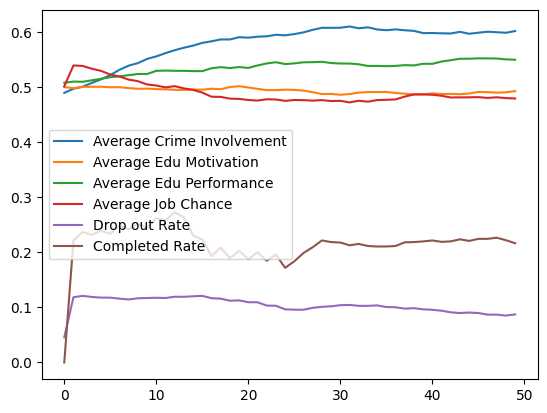

In [6]:
model_data.plot()
plt.show()

In [7]:
# pd.set_option('display.max_rows', None)
# agent_data

agent_data.xs(1889, level="AgentID")

,Type,Age,Crime Involvement,Edu Motivation,Edu Performance,Job Chance,School status
Step,,,,,,,
1,YouthAgent,20.0,0.814501,0.477660,0.348167,0.629243,enrolled
2,YouthAgent,20.5,0.834501,0.475313,0.353167,0.619243,at_risk
3,YouthAgent,21.0,0.834501,0.472882,0.358167,0.619243,at_risk
4,YouthAgent,21.5,0.834501,0.470368,0.363167,0.619243,at_risk
5,YouthAgent,22.0,0.854501,0.467669,0.368167,0.609243,at_risk
6,YouthAgent,22.5,0.874501,0.464782,0.373167,0.599243,at_risk
7,YouthAgent,23.0,0.894501,0.461705,0.378167,0.589243,at_risk
8,YouthAgent,23.5,0.914501,0.458437,0.383167,0.579243,at_risk


Nog naar kijken:
- Meerdere scholen neem ik aan
- Hoe hebben friends invloed?
- Arnhem info erin verwerken als input (zoals aantal neighborhoods, wat daar de percentages zijn etc)
- Wat willen we met de drop outs? EN met completed?
- Wat met risk_propesity?